<a href="https://colab.research.google.com/github/germanjke/segmentation_of_cigg_butts/blob/master/cigarette_butt_segmentation/notebooks/please_dont_smoke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download data & import libs 

In [1]:
!git clone https://github.com/germanjke/segmentation_of_cigg_butts.git

Cloning into 'segmentation_of_cigg_butts'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 236 (delta 3), reused 0 (delta 0), pack-reused 219
Receiving objects: 100% (236/236), 1.07 MiB | 1.23 MiB/s, done.
Resolving deltas: 100% (98/98), done.


In [2]:
from IPython.display import clear_output

In [3]:
!pip install -U git+https://github.com/albu/albumentations --no-ca
clear_output(wait=True)
!pip install segmentation_models_pytorch
clear_output(wait=True)
print('Last versions of albumentations and segmentation_models_pytorch are downloaded')

Last versions of albumentations and segmentation_models_pytorch are downloaded


In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.chdir("/content/segmentation_of_cigg_butts/cigarette_butt_segmentation")

import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import cv2
import json
import pandas as pd
from PIL import Image

from glob import glob

from lib import *

%matplotlib inline

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
DATA_DIR = '/content/drive/My Drive/ciggs/data/cig_butts/'

x_train_dir = os.path.join(DATA_DIR, 'train/images')
y_train_dir = os.path.join(DATA_DIR, 'train_masks')

x_valid_dir = os.path.join(DATA_DIR, 'val/images')
y_valid_dir = os.path.join(DATA_DIR, 'val_masks')

x_test_dir = os.path.join(DATA_DIR, 'real_test')
y_test_dir = os.path.join(DATA_DIR, 'test_masks')

In [7]:
download_masks('/content/drive/My Drive/ciggs/data/cig_butts/train', '/content/drive/My Drive/ciggs/data/cig_butts/train_masks/')
download_masks('/content/drive/My Drive/ciggs/data/cig_butts/val', '/content/drive/My Drive/ciggs/data/cig_butts/val_masks/')

100%|██████████| 200/200 [00:02<00:00, 80.84it/s]


## Prepare dataset

In [7]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['cigg'])


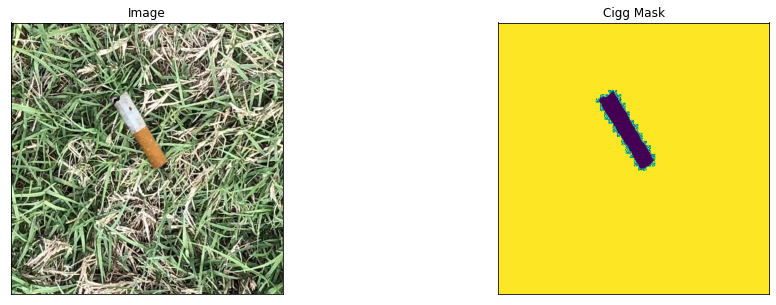

In [8]:
image, mask = dataset[1999] # get some sample
visualize(
    image=image, 
    cigg_mask=mask.squeeze(),
)

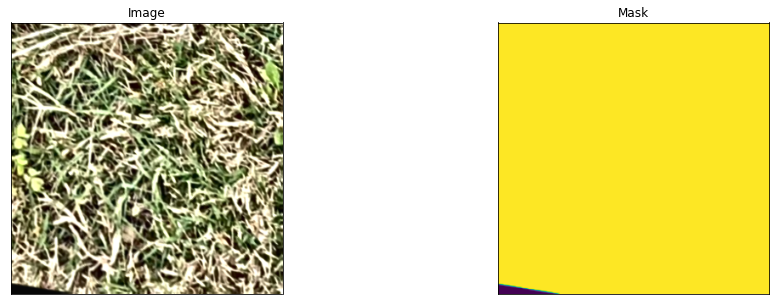

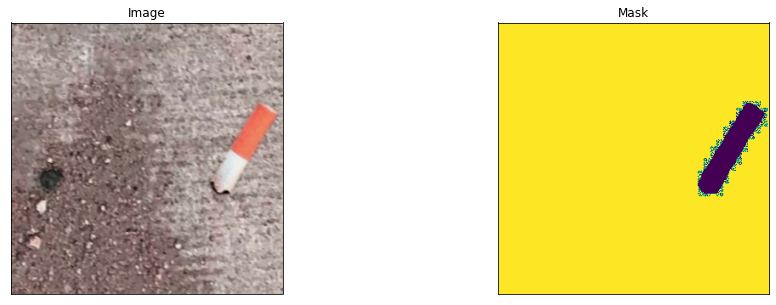

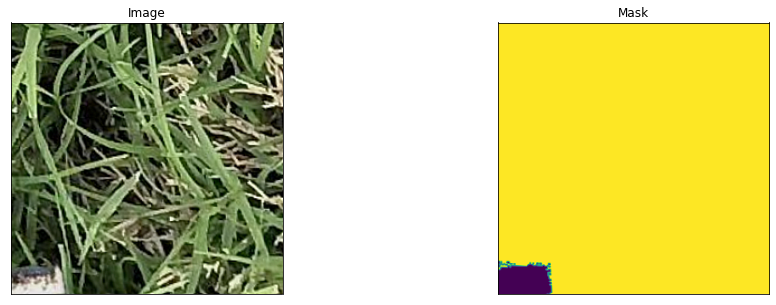

In [9]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['cigg'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[i]
    visualize(image=image, mask=mask.squeeze(-1))

## Model

In [10]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import segmentation_models_pytorch as smp

In [11]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['cigg']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'


# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [12]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [13]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [14]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
# train model for 40 epochs

train_dict = {}
valid_dict = {}
max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    train_dict[i] = train_logs['dice_loss']
    valid_dict[i] = valid_logs['dice_loss']
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, '/content/drive/My Drive/ciggs/best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

In [16]:
# load best saved checkpoint
best_model = torch.load('/content/drive/My Drive/ciggs/best_model.pth')

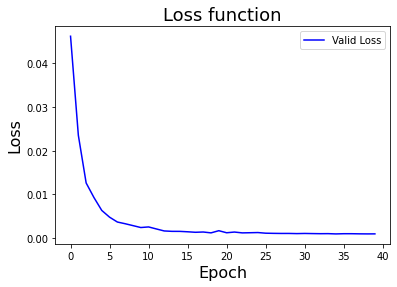

In [ ]:
visualize_losses(valid_dict, model)

## Check on test data

In [17]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [18]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

In [19]:
pred = pd.read_csv("data/pred_val_template.csv")
pred.head()

,img_id,rle_mask
0,0,171654 1 172158 1 172164 5 172670 3 172674 12 ...
1,1,171654 1 172158 1 172164 5 172670 3 172674 12 ...
2,2,171654 1 172158 1 172164 5 172670 3 172674 12 ...
3,3,171654 1 172158 1 172164 5 172670 3 172674 12 ...
4,4,171654 1 172158 1 172164 5 172670 3 172674 12 ...


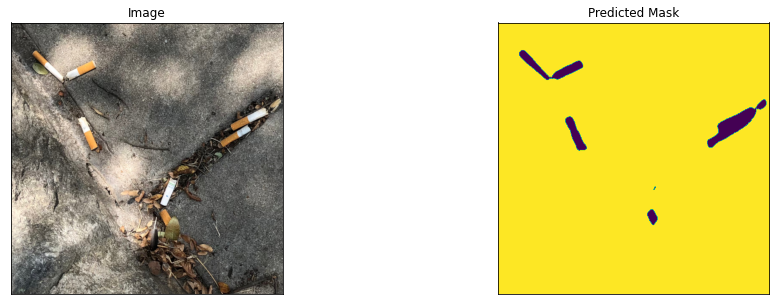

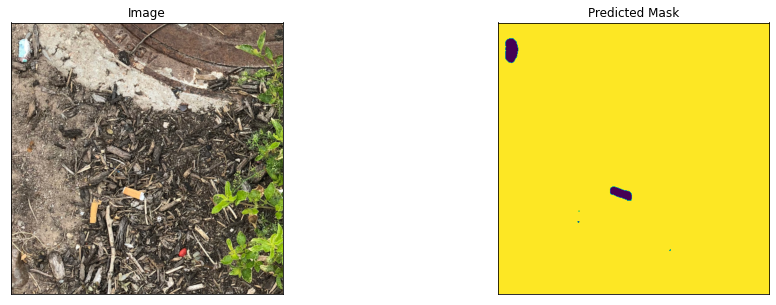

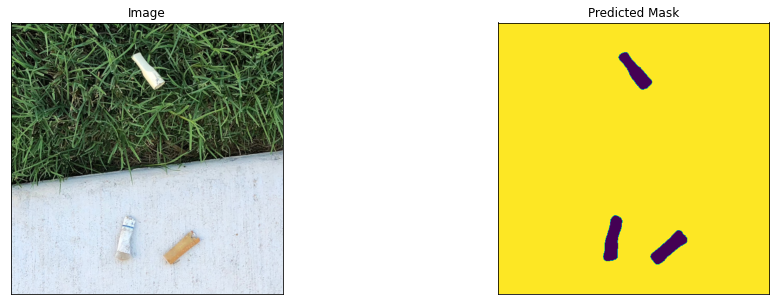

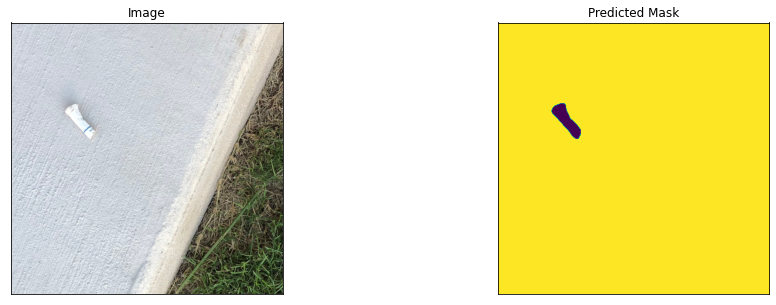

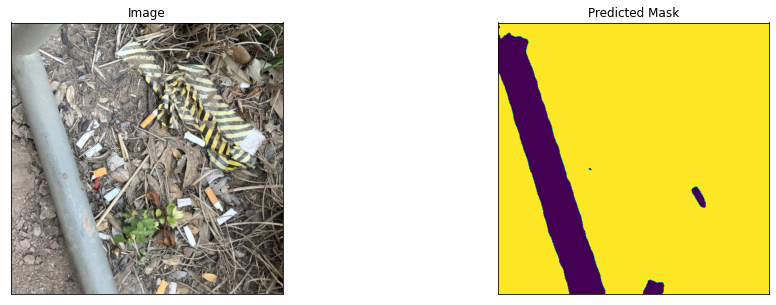

In [20]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

        
    visualize(
        image=image_vis, 
        predicted_mask=pr_mask
    )

In [21]:
masks = []
masks_images = []

for i in range(len(pred)):
    
    image, gt_mask = valid_dataset[i]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    masks_images.append(pr_mask)
    
    masks.append(encode_rle(pr_mask))


In [22]:
pred['rle_mask'] = masks
pred.head()

,img_id,rle_mask
0,0,1 90781 90790 502 91307 496 91822 492 92337 48...
1,1,1 48370 48376 505 48890 502 49403 500 49916 49...
2,2,1 26467 26476 502 26990 499 27503 497 28016 49...
3,3,1 73563 73573 499 74088 494 74603 489 75116 48...
4,4,1 23793 23804 496 24318 489 24830 485 25343 48...


In [23]:
pred.to_csv(f'/content/segmentation_of_cigg_butts/cigarette_butt_segmentation/data/pred_val_{model.name}.csv')

In [24]:
_ = get_html(glob('/content/drive/My Drive/ciggs/data/cig_butts/val/images/*'), masks_images, path_to_save="/content/drive/My Drive/ciggs/html/examples_html")

## Few of examples

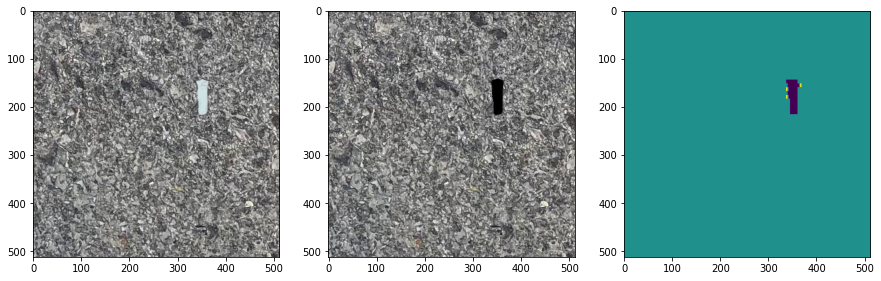

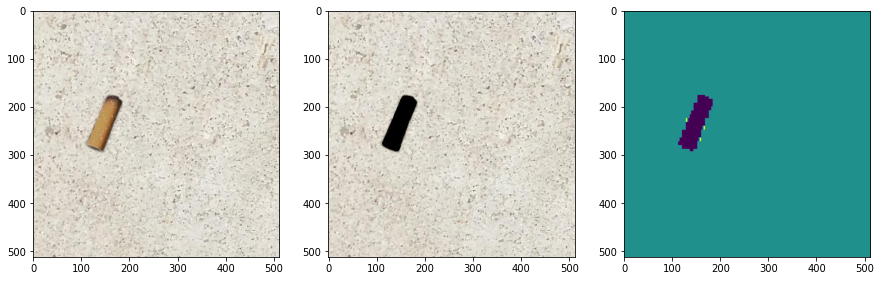

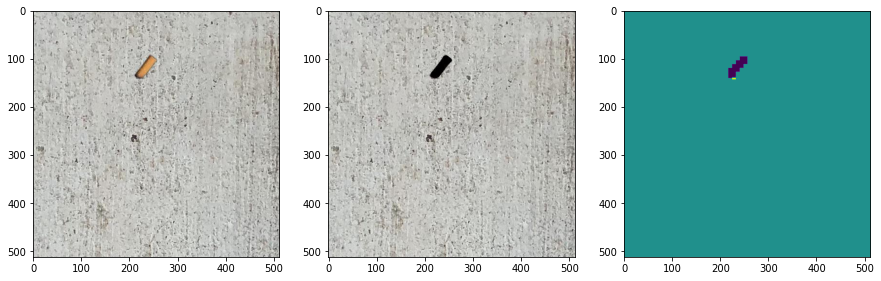

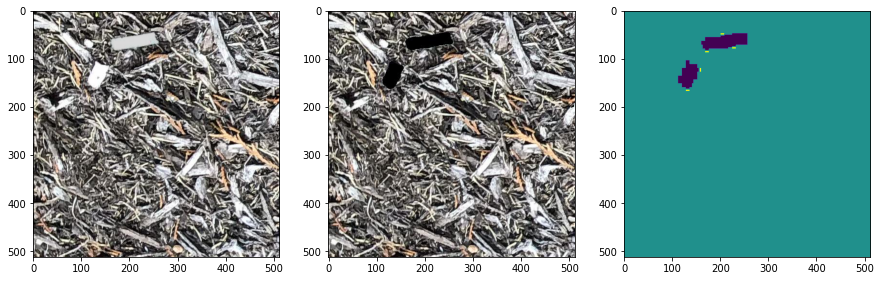

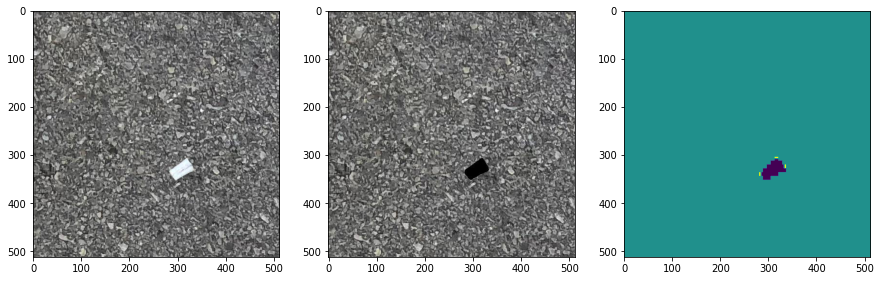

In [25]:
import matplotlib.image as mpimg
for i in range(5):
  fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,15))
  img1 = mpimg.imread(f'/content/drive/My Drive/ciggs/html/examples_html/0000000{i}_img.jpg')
  img2 = mpimg.imread(f'/content/drive/My Drive/ciggs/html/examples_html/0000000{i}_crop.jpg')
  img3 = mpimg.imread(f'/content/drive/My Drive/ciggs/html/examples_html/0000000{i}_pred_mask.jpg')
  ax1.imshow(img1)
  ax2.imshow(img2)
  ax3.imshow(img3)
  plt.show()
